<a href="https://colab.research.google.com/github/Freddy-94/Thesis_Project_GAN/blob/main/Thesis_Project_GAN_Optimized_Sub_S%26P400_ST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Alfredo Bernal Luna
### December 22nd 2024
### GAN implementation to forecast stock market prices (LSGAN version - S&P400 Index Subset - Z-Score normalization over a window of 20 days - Same time for historic prices)

In this project, we define a GAN architecture with a three-layer dense network as the generator, and a three-layer CNN as the discriminator.

The **Generator** uses three fully connected (Dense) layers:

1.   First layer: The first dense layer with size generator_output_size * 10 followed by a ReLU activation.
2.   Second layer: The second dense layer with size generator_output_size * 5 also followed by ReLU 'generator_output_size'.
3. Third layer: The final dense layer outputs the reshaped data with dimensions (num_historical_days, num_features) to match the stock price time series data format.

The **Discriminator** uses three convolutional layers:

1. Conv2D layers with 32, 64, and 128 filters, respectively, followed by ReLU activations.
2. Dropout layers are added for regularization during training.
3. A Flatten layer and two Dense layers, with the final Dense layer outputting a single value, which aligns with the Least Squares GAN (LSGAN) loss function.

Our GAN model will generate synthetic features from stock price data, which will be then used as inputs for an XGBoost model to predict stock price movements. The XGBoost model is used to perform classification to predict whether stock prices will go up or down after a certain number of days (defined by the constant 'DAYS_AHEAD').

The features for XGBoost are GAN-generated synthetic stock sequences flattened to 1D arrays, and the labels are computed based on the percent change in the stock's closing price over a given time horizon (in our case, 1 day ahead). If the percent change is greater than the threshold 'pct_change', the label is 1 (indicating an upward movement), otherwise, it is 0 (indicating a downward movement).

The XGBoost model is trained to predict these labels, i.e., whether the stock price will go up or down based on the features generated by the GAN.

**Data Flow and Preprocessing**:

*   Training Data:
  1.   The raw stock data is normalized using **Z-Score normalization** over a window of num_historical_days.
  2.   We split the dataset into training and test sets. For training, the GAN generates synthetic sequences for the training set, which are used as inputs for XGBoost. The labels for training are derived from the actual stock price movements.

*   Test Data:
  1.  Similar to the training data, we use the GAN to generate synthetic stock data sequences for the test set. These synthetic sequences serve as input for the XGBoost model during evaluation.
  2.   The test labels are derived from the real stock data’s price movements (percent change over 1 day).

**XGBoost Training and Evaluation**:

We train the XGBoost model with the GAN-generated features using a softmax objective for binary classification (i.e., whether the stock price will go up or down), and track performance using the mlogloss metric. Further, we perform early stopping based on the evaluation on the test set.

After the training, the model's predictions on the test set are compared to the actual labels (up/down movements). We use a confusion matrix to evaluate the model’s accuracy, measuring how well the XGBoost model, trained on GAN-generated features, is able to predict stock price movements.

**GAN-XGBoost Combination achievments**:

The combination of GAN and XGBoost in this project serves two main purposes:

1.   **Synthetic Data Generation**: The GAN generates synthetic stock price data sequences that capture realistic market patterns, potentially providing better input features for prediction.
2.   **Stock Price Movement Prediction**: XGBoost uses these synthetic sequences to predict whether the stock price will rise or fall after a given time frame, based on the historical patterns captured by the GAN.

### To mount your Google Drive to the Colab environment

In [ ]:
# GOOGLE DRIVE - COLAB
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

# After executing the line above, Drive
# files will be present in "/content/drive/My Drive".
# !ls "/content/drive/My Drive"

Mounted at /content/drive


### Global variables used in the project

In [ ]:
# googlepath exists for googledrive finding the files.
# Have companylist.csv in same dir. Will create
# a stock_data folder and download stocks data into it.
googlepath = "drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/"

# Setting the Training Amount
TRAINING_AMOUNT = 50000 # 50000
SAVE_STEPS_AMOUNT = 10000 # testing for now
PCT_CHANGE_AMOUNT = 0.001 # just want to see up down trends ORIGINAL 5
HISTORICAL_DAYS_AMOUNT = 20
DAYS_AHEAD = 1 # ORIGINAL 5

### Get data from Alpha Vantage

In [ ]:
'''
Downloads stock data from alphavantage
'''
import pandas as pd
import os
import time
import urllib
import json
import csv
import requests
import io
from pathlib import Path
import random

ALPHA_VANTAGE_KEY = "XXXXXXXXXX"

'''
Saves data to a file
'''
def save(googlepath, stock_csv, output_dir, filename):
    try:
        output_path = os.path.join(googlepath, output_dir)
        if not os.path.exists(output_path):
            os.makedirs(output_path)

        filepath = os.path.join(output_path, filename)

        if not stock_csv.empty:
            if 'timestamp' in stock_csv.columns:
                stock_csv = stock_csv.sort_values(by='timestamp')
            stock_csv.to_csv(filepath, index=False)
            print(f"Saved data to {filepath}")
        else:
            print(f"DataFrame is empty for {filename}. Nothing to save.")
    except Exception as ex:
        print(f'Could not open file {filepath} to write data')
        print(ex)

def try_download(symbol):
    try:
        time.sleep(12)
        url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={ALPHA_VANTAGE_KEY}&datatype=csv&outputsize=full'
        c = pd.read_csv(url)
        if c.empty:
            raise ValueError(f"No data fetched for {symbol}")
        return c, True
    except Exception as ex:
        print(f"Error fetching data for {symbol}: {ex}")
        return None, None

#Given a stock symbol (aka 'goog') will download and save the data to the
#output dir as a csv

def download_symbol(symbol, output_dir, retry_count=4):
    stock_csv, didPass = try_download(symbol)
    if didPass:
        save(googlepath, stock_csv, output_dir, '{}.csv'.format(symbol))
    else:
        print('Failed to download {}'.format(symbol))


df = pd.read_csv(f"{googlepath}/companylist.csv")
for symbol in df.Symbol:
    my_file = Path(f"{googlepath}/stock_data/{symbol}.csv")  # check if already downloaded
    if not my_file.exists():
        print('Downloading {}'.format(symbol))
        download_symbol(symbol, 'stock_data')
    else:
        print(f"Already downloaded {symbol}")

Already downloaded AAON
Already downloaded ACHC
Already downloaded ADC
Already downloaded AFG
Already downloaded AGCO
Already downloaded AIT
Already downloaded ALE
Already downloaded ALV
Already downloaded AMED
Already downloaded AMG
Already downloaded AMKR
Already downloaded AN
Already downloaded ANF
Already downloaded ARW
Already downloaded ARWR
Already downloaded ASB
Already downloaded ASGN
Already downloaded ASH
Already downloaded ATR
Already downloaded AVNT
Already downloaded AVT
Already downloaded AZPN
Already downloaded AZTA
Already downloaded BC
Already downloaded BCO
Already downloaded BDC
Already downloaded BIO
Already downloaded BKH
Already downloaded BMRN
Already downloaded BYD
Already downloaded CACI
Already downloaded CADE
Already downloaded CAR
Already downloaded CASY
Already downloaded CBSH
Already downloaded CBT
Already downloaded CCK
Already downloaded CDP
Already downloaded CFR
Already downloaded CGNX
Already downloaded CHDN
Already downloaded CHE
Already downloaded 

### Confusion Matrix plot definition

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim([1.5, -.5])


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    #thresh = cm.max() / 2. # Previous
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() - 0.05

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #print (cm[i, j])
        plt.text(j, i, format(cm[i, j],fmt),
                 horizontalalignment="center",
                 fontsize=24,
                 color="white" if cm[i, j] > thresh else "black")

    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #    plt.text(j, i, cm[i, j],
    #             horizontalalignment="center",
    #             color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Initializing the GAN definition

In [ ]:
import tensorflow as tf
import numpy as np

class GAN(tf.keras.Model):
    def __init__(self, num_features, num_historical_days, generator_input_size=200, is_train=True):
        super(GAN, self).__init__()
        self.num_features = num_features
        self.num_historical_days = num_historical_days
        self.generator_input_size = generator_input_size
        self.is_train = is_train

        # Build generator and discriminator
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()

    def sample_Z(self, batch_size, n):
        return np.random.uniform(-1., 1., size=(batch_size, n))

    def build_generator(self):
        model = tf.keras.Sequential()
        generator_output_size = self.num_features * self.num_historical_days

        model.add(tf.keras.layers.Dense(generator_output_size * 10, input_dim=self.generator_input_size))
        model.add(tf.keras.layers.Activation('relu'))

        model.add(tf.keras.layers.Dense(generator_output_size * 5))
        model.add(tf.keras.layers.Activation('relu'))

        model.add(tf.keras.layers.Dense(generator_output_size))
        model.add(tf.keras.layers.Reshape((self.num_historical_days, self.num_features)))

        return model

    def build_discriminator(self):
        model = tf.keras.Sequential()

        model.add(tf.keras.layers.Conv2D(32, (3, 1), input_shape=(self.num_historical_days, 1, self.num_features), padding='same'))
        model.add(tf.keras.layers.ReLU())
        if self.is_train:
            model.add(tf.keras.layers.Dropout(0.3))

        model.add(tf.keras.layers.Conv2D(64, (3, 1), padding='same'))
        model.add(tf.keras.layers.ReLU())
        if self.is_train:
            model.add(tf.keras.layers.Dropout(0.3))

        model.add(tf.keras.layers.Conv2D(128, (3, 1), padding='valid'))
        model.add(tf.keras.layers.ReLU())
        if self.is_train:
            model.add(tf.keras.layers.Dropout(0.3))

        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(128))
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.Dense(1)) # LSGAN

        return model

    def call(self, inputs, training=False):
        noise, real_data = inputs
        generated_data = self.generator(noise, training=training)
        generated_data = tf.reshape(generated_data, [-1, self.num_historical_days, 1, self.num_features])
        real_data = tf.reshape(real_data, [-1, self.num_historical_days, 1, self.num_features])

        real_output = self.discriminator(real_data, training=training)
        fake_output = self.discriminator(generated_data, training=training)

        return real_output, fake_output, generated_data

    def discriminator_loss(self, real_output, fake_output):
        real_loss = tf.reduce_mean((real_output - 1) ** 2)
        fake_loss = tf.reduce_mean(fake_output ** 2)
        return real_loss + fake_loss

    def generator_loss(self, fake_output):
        return tf.reduce_mean((fake_output - 1) ** 2)


### Tensorflow version

In [ ]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.17.1
Eager execution is: True


### Training the GAN

drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/ANF.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/ALV.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/AMED.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/ALE.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/AMG.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/AIT.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/AMKR.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/AN.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/ACHC.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/AAON.csv
drive/MyDrive/Col

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step=99 D_loss=nan G_loss=nan
Step=199 D_loss=nan G_loss=nan
Step=299 D_loss=nan G_loss=nan
Step=399 D_loss=nan G_loss=nan
Step=499 D_loss=nan G_loss=nan
Step=599 D_loss=nan G_loss=nan
Step=699 D_loss=nan G_loss=nan
Step=799 D_loss=nan G_loss=nan
Step=899 D_loss=nan G_loss=nan
Step=999 D_loss=nan G_loss=nan
Step=1099 D_loss=nan G_loss=nan
Step=1199 D_loss=nan G_loss=nan
Step=1299 D_loss=nan G_loss=nan
Step=1399 D_loss=nan G_loss=nan
Step=1499 D_loss=nan G_loss=nan
Step=1599 D_loss=nan G_loss=nan
Step=1699 D_loss=nan G_loss=nan
Step=1799 D_loss=nan G_loss=nan
Step=1899 D_loss=nan G_loss=nan
Step=1999 D_loss=nan G_loss=nan
Step=2099 D_loss=nan G_loss=nan
Step=2199 D_loss=nan G_loss=nan
Step=2299 D_loss=nan G_loss=nan
Step=2399 D_loss=nan G_loss=nan
Step=2499 D_loss=nan G_loss=nan
Step=2599 D_loss=nan G_loss=nan
Step=2699 D_loss=nan G_loss=nan
Step=2799 D_loss=nan G_loss=nan
Step=2899 D_loss=nan G_loss=nan
Step=2999 D_loss=nan G_loss=nan
Step=3099 D_loss=nan G_loss=nan
Step=3199 D_loss=na

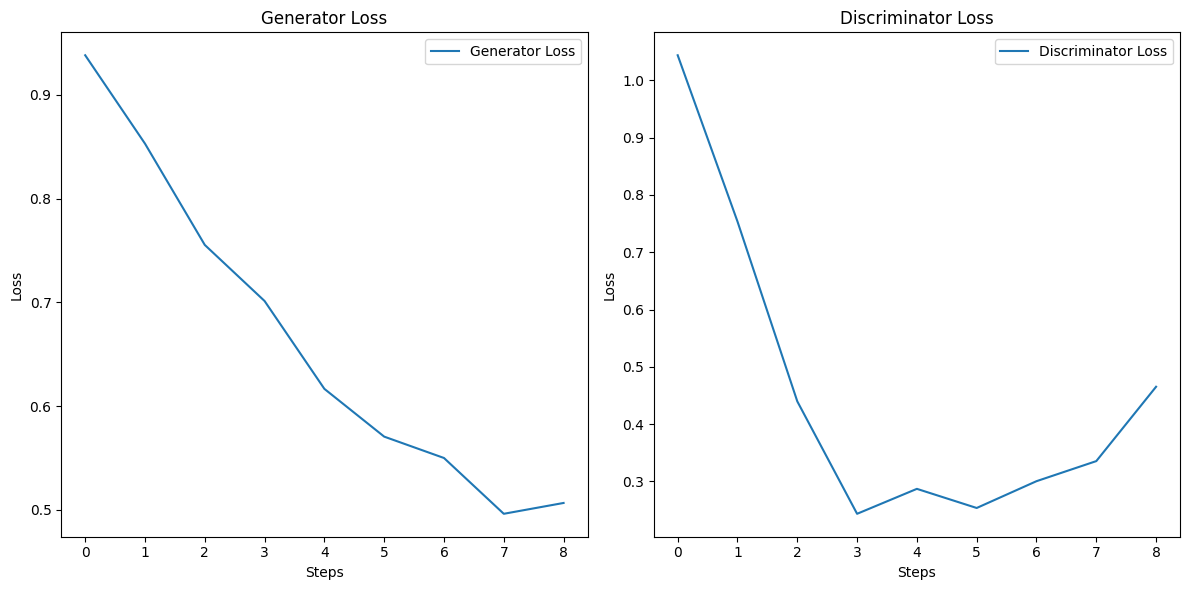

In [ ]:
import tensorflow as tf
import numpy as np
import random
import os
import pandas as pd
import matplotlib.pyplot as plt

random.seed(24)

class TrainGan:
    def __init__(self, num_historical_days, batch_size=128):
        self.batch_size = batch_size
        self.data = []

        files = [f"{googlepath}stock_data/{f}" for f in os.listdir(f"{googlepath}stock_data")]

        for file in files:
            print(file)
            df = pd.read_csv(file, index_col='timestamp', parse_dates=True)
            df = df[['open', 'high', 'low', 'close', 'volume']]

            df = (df - df.rolling(num_historical_days).mean().shift(-num_historical_days)) / df.rolling(num_historical_days).std().shift(-num_historical_days)

            df = df.dropna()
            df = df[400:]

            for i in range(num_historical_days, len(df), num_historical_days):
                self.data.append(df.values[i-num_historical_days:i])

        self.gan = GAN(num_features=5, num_historical_days=num_historical_days,
                       generator_input_size=200)

        # Optimizers
        self.G_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000055)
        self.D_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

        # Initialize lists for loss tracking
        self.g_loss_array = []
        self.d_loss_array = []

    def random_batch(self, batch_size=128):
        batch = []
        while True:
            batch.append(random.choice(self.data))
            if len(batch) == batch_size:
                yield batch
                batch = []

    def train(self, print_steps=100, display_data=100, save_steps=1000):
        if not os.path.exists(f'{googlepath}models'):
            os.makedirs(f'{googlepath}models')

        current_step = 0

        for i, X in enumerate(self.random_batch(self.batch_size)):
            noise = self.gan.sample_Z(self.batch_size, 200)

            with tf.GradientTape() as tape:
                D_real, D_fake, _ = self.gan((noise, X), training=True)
                D_loss = self.gan.discriminator_loss(D_real, D_fake) # LSGAN

            grads = tape.gradient(D_loss, self.gan.discriminator.trainable_variables)
            self.D_optimizer.apply_gradients(zip(grads, self.gan.discriminator.trainable_variables))

            with tf.GradientTape() as tape:
                _, D_fake, _ = self.gan((noise, X), training=True)
                G_loss = self.gan.generator_loss(D_fake) # LSGAN

            grads = tape.gradient(G_loss, self.gan.generator.trainable_variables)
            self.G_optimizer.apply_gradients(zip(grads, self.gan.generator.trainable_variables))

            # Record losses
            self.g_loss_array.append(G_loss.numpy())
            self.d_loss_array.append(D_loss.numpy())

            if (i + 1) % print_steps == 0:
                print(f'Step={i + current_step} D_loss={D_loss.numpy()} G_loss={G_loss.numpy()}')

            if (i + 1) % save_steps == 0:
                self.gan.save_weights(f'{googlepath}/models/gan.weights.h5')

            if ((i + current_step) > TRAINING_AMOUNT):
                print(f"Reached {i + current_step} epochs for GAN")
                break

        # Plot the losses
        self.plot_losses()

    def plot_losses(self):
        plt.figure(figsize=(12, 6))

        # Plot generator loss
        plt.subplot(1, 2, 1)
        plt.plot(self.g_loss_array, label='Generator Loss')
        plt.title('Generator Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()

        # Plot discriminator loss
        plt.subplot(1, 2, 2)
        plt.plot(self.d_loss_array, label='Discriminator Loss')
        plt.title('Discriminator Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

gan = TrainGan(HISTORICAL_DAYS_AMOUNT, 128)
gan.train()

### Train XGBoost

In [ ]:
!pip install xgboost

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

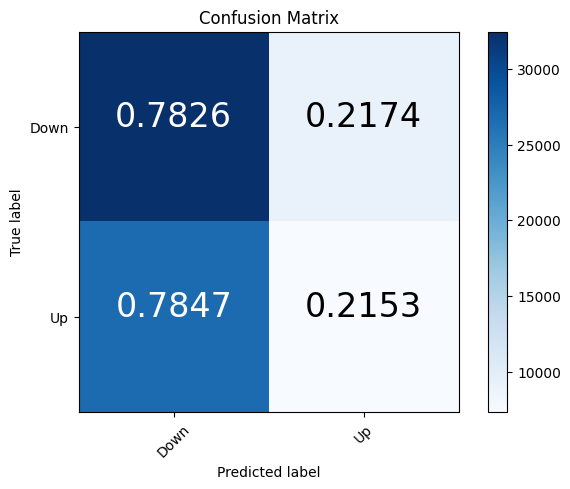

Feature importance (by weight): [('f79', 3730.0), ('f73', 3691.0), ('f7', 3590.0), ('f40', 3533.0), ('f37', 3460.0), ('f6', 3450.0), ('f22', 3316.0), ('f69', 3273.0), ('f99', 3236.0), ('f39', 3179.0), ('f35', 3168.0), ('f32', 3158.0), ('f87', 3092.0), ('f85', 3077.0), ('f43', 3076.0), ('f71', 3076.0), ('f94', 3073.0), ('f53', 3050.0), ('f57', 3050.0), ('f92', 3032.0), ('f23', 3030.0), ('f46', 3017.0), ('f27', 2978.0), ('f95', 2952.0), ('f4', 2942.0), ('f3', 2939.0), ('f88', 2930.0), ('f72', 2900.0), ('f58', 2896.0), ('f2', 2895.0), ('f60', 2884.0), ('f29', 2883.0), ('f10', 2820.0), ('f47', 2813.0), ('f86', 2804.0), ('f91', 2710.0), ('f42', 2698.0), ('f81', 2696.0), ('f56', 2666.0), ('f28', 2661.0), ('f48', 2661.0), ('f63', 2626.0), ('f80', 2616.0), ('f21', 2615.0), ('f65', 2607.0), ('f76', 2599.0), ('f70', 2574.0), ('f90', 2547.0), ('f5', 2537.0), ('f18', 2533.0), ('f31', 2532.0), ('f67', 2528.0), ('f84', 2514.0), ('f96', 2513.0), ('f55', 2492.0), ('f9', 2491.0), ('f25', 2447.0), ('f34

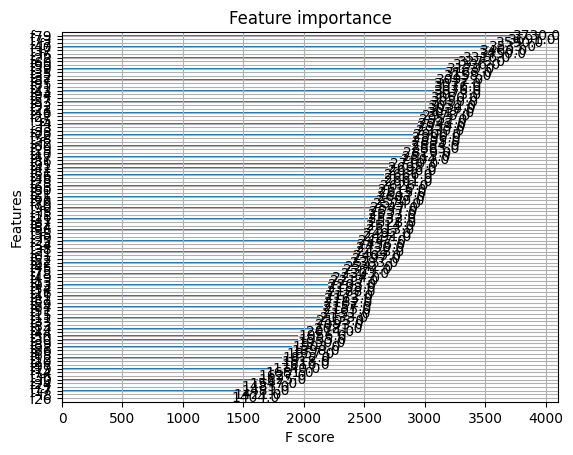

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from joblib import dump

class TrainXGBBoost:
    def __init__(self, num_historical_days, days=10, pct_change=0):
        self.data = []
        self.labels = []
        self.test_data = []
        self.test_labels = []

        # Initialize GAN model
        checkpoint_path = f'{googlepath}models/checkpoint'
        self.gan = GAN(num_features=5, num_historical_days=num_historical_days,
                       generator_input_size=200, is_train=False)

        if os.path.exists(checkpoint_path):
            self.gan.load_weights(f'{googlepath}/models/gan.weights.h5')
        else:
            print(f"No checkpoint found at {checkpoint_path}. Proceeding without it.")

        # Load and preprocess stock data
        files = [os.path.join(f'{googlepath}stock_data', f) for f in os.listdir(f'{googlepath}/stock_data')]
        for file in files:
            print(file)
            df = pd.read_csv(file, index_col='timestamp', parse_dates=True)
            df = df[['open', 'high', 'low', 'close', 'volume']]

            # Compute labels
            labels = df.close.pct_change(days).map(lambda x: int(x > pct_change / 100.0))
            # Check class distribution    NEW LINE
            label_counts = labels.value_counts()  # Check class distribution
            print(f"Class distribution: \n{label_counts}")

            # Calculate scale_pos_weight
            #scale_pos_weight = label_counts[0] / label_counts[1]

            df = (df - df.rolling(num_historical_days).mean().shift(-num_historical_days)) / df.rolling(num_historical_days).std().shift(-num_historical_days)
            df['labels'] = labels
            df = df.dropna()

            # Split into training and testing data
            test_df = df[:365]
            df = df[400:]

            data = df[['open', 'high', 'low', 'close', 'volume']].values
            labels = df['labels'].values

            noise_dim = 200
            for i in range(num_historical_days, len(df), num_historical_days):
                noise = tf.random.normal([1, noise_dim])
                features = self.gan.generator.predict(noise)

                # Flatten the features to 1D array
                self.data.append(features[0].flatten())
                self.labels.append(labels[i-1])

            data = test_df[['open', 'high', 'low', 'close', 'volume']].values
            labels = test_df['labels'].values
            for i in range(num_historical_days, len(test_df), 1):
                noise = tf.random.normal([1, noise_dim])
                features = self.gan.generator.predict(noise)

                # Flatten the features to 1D array
                self.test_data.append(features[0].flatten())
                self.test_labels.append(labels[i-1])

        # Store the scale_pos_weight for later use
        #self.scale_pos_weight = scale_pos_weight

    def train(self):
        # XGBoost parameters including the scale_pos_weight
        params = {
            'objective': 'multi:softprob',
            'eta': 0.01, # 0.01
            'num_class': 2,
            'max_depth': 20, #20
            'subsample': 0.05, # 0.05
            'colsample_bytree': 0.05, # 0.05
            'eval_metric': 'mlogloss'#,
            #'scale_pos_weight': 3,  # Add the calculated scale_pos_weight
            #'alpha': 0.5,  # L1 regularization
            #'lambda': 2.0  # L2 regularization
        }

        # Convert lists to numpy arrays for xgboost DMatrix
        train_data = xgb.DMatrix(np.array(self.data), label=np.array(self.labels))
        test_data = xgb.DMatrix(np.array(self.test_data), label=np.array(self.test_labels))

        watchlist = [(train_data, 'train'), (test_data, 'test')]
        clf = xgb.train(params, train_data, 1000, evals=watchlist, early_stopping_rounds=100)

        # Save the model
        dump(clf, f'{googlepath}models/clf.pkl')

        # Predict and compute confusion matrix
        predictions = clf.predict(test_data)
        cm = confusion_matrix(self.test_labels, list(map(lambda x: int(x[1] > .5), predictions)))
        print(cm)

        # Plot confusion matrix if necessary
        plot_confusion_matrix(cm, ['Down', 'Up'], normalize=True, title="Confusion Matrix")

        # Feature importance
        importance = clf.get_score(importance_type='weight')
        importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
        print("Feature importance (by weight):", importance)

        # Plot feature importance
        xgb.plot_importance(clf)
        plt.show()

# Example usage:
boost_model = TrainXGBBoost(num_historical_days=HISTORICAL_DAYS_AMOUNT, days=DAYS_AHEAD, pct_change=PCT_CHANGE_AMOUNT)
boost_model.train()


In [ ]:
import os

# Below Code Gets Rid of Copy Of when making a copy of the models.
for filename in os.listdir(f'{googlepath}models/'):
    split = filename.split(" ")
    if len(split) == 2:
        os.rename(f'{googlepath}models/{filename}', f'{googlepath}models/{split[1]}')
    else:
        print("Nothing to rename.")

# Below Code Gets Rid of Checkpoint Number in Name
for filename in os.listdir(f'{googlepath}models/'):
    split = filename.split(".")
    if len(split) == 3:
        prefix, _, suffix = split
        new_name = prefix + "." + suffix
        os.rename(f'{googlepath}models/{filename}', f'{googlepath}models/{new_name}')
    elif filename == "clf.pkl":
        os.rename(f'{googlepath}models/{filename}', f'{googlepath}models/xgb')
    else:
        print("Nothing to rename.")


Nothing to rename.
Nothing to rename.


### Get the Predictions

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import xgboost as xgb

tf.config.run_functions_eagerly(True)  # Enable eager execution

class Predict:
    def __init__(self, num_historical_days=20, days=10, pct_change=0,
                 gan_weights_path=f'{googlepath}models/gan.h5',
                 xgb_model_path=f'{googlepath}models/xgb'):
        self.num_historical_days = num_historical_days
        self.gan_weights_path = gan_weights_path
        self.xgb_model_path = xgb_model_path
        self.data = []

        # Check if the model files exist
        for model_path in [self.gan_weights_path, self.xgb_model_path]:
            if not os.path.exists(model_path):
                raise FileNotFoundError(f"No file found at {model_path}")

        # Load and preprocess stock data
        files = [os.path.join(f'{googlepath}stock_data', f) for f in os.listdir(f'{googlepath}stock_data')]
        for file in files:
            print(file)
            df = pd.read_csv(file, index_col='timestamp', parse_dates=True)
            df = df.sort_index(ascending=False)
            df = df[['open', 'high', 'low', 'close', 'volume']]
            df = (df - df.rolling(num_historical_days).mean().shift(-num_historical_days)) / df.rolling(num_historical_days).std().shift(-num_historical_days)
            df = df.dropna()
            if len(df) >= self.num_historical_days + 200:
                self.data.append((file.split('/')[-1], df.index[0], df[200:200 + self.num_historical_days].values))

    def build_gan_model(self):
        """Rebuild the GAN model architecture."""
        model = GAN(num_features=5, num_historical_days=self.num_historical_days,
                    generator_input_size=200, is_train=False)
        return model

    def load_gan_model(self):
        """Load the GAN model and its weights."""
        gan = self.build_gan_model()
        try:
            # Initialize model to create the graph
            dummy_noise = tf.random.normal([1, 200])  # Adjust shape based on GAN architecture
            dummy_data = tf.random.normal([1, self.num_historical_days, 5])  # Adjust shape based on GAN architecture
            _ = gan((dummy_noise, dummy_data), training=False)  # Ensure the model is built and variables are created

            # Load weights now that the model is initialized
            gan.load_weights(self.gan_weights_path, by_name=True)  # Try loading weights by name
            print("GAN weights loaded successfully.")
            return gan
        except Exception as e:
            print(f"Error loading GAN weights: {e}")
            return None

    def load_xgb_model(self):
        """Load the XGBoost model."""
        try:
            clf = joblib.load(self.xgb_model_path)
            print("XGBoost model loaded successfully.")
            return clf
        except Exception as e:
            print(f"Error loading XGBoost model: {e}")
            return None

    def gan_predict(self):
        gan = self.load_gan_model()
        if gan is None:
            print("Invalid GAN model.")
            return

        clf = self.load_xgb_model()
        if clf is None:
            print("Invalid XGBoost model.")
            return

        for sym, date, data in self.data:
            # Prepare data for GAN prediction
            data = np.expand_dims(data, axis=0)  # Adding batch dimension
            noise = tf.random.normal([1, 200])  # Assuming noise_dim is 200
            generated_features = gan.generator.predict(noise)
            generated_features = generated_features.flatten().reshape(1, -1)  # Flatten and reshape for XGBoost

            features = xgb.DMatrix(generated_features)

            # Predict using XGBoost model
            prediction = clf.predict(features)
            print(f'{str(date).split(" ")[0]} {sym} Prediction: {prediction[0]}')

# Example usage
predictor = Predict(num_historical_days=HISTORICAL_DAYS_AMOUNT, days=DAYS_AHEAD, pct_change=PCT_CHANGE_AMOUNT)
predictor.gan_predict()

drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/ANF.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/ALV.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/AMED.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/ALE.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/AMG.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/AIT.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/AMKR.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/AN.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/ACHC.csv
drive/MyDrive/Colab Notebooks/Thesis_Project_GAN_Optimized_Sub_S&P400_SameTime/stock_data/AAON.csv
drive/MyDrive/Col

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


GAN weights loaded successfully.
XGBoost model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2024-10-28 ANF.csv Prediction: [0.47539884 0.52460116]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2024-10-28 ALV.csv Prediction: [0.47333962 0.5266604 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2024-10-28 AMED.csv Prediction: [0.4968489  0.50315106]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2024-10-28 ALE.csv Prediction: [0.50073886 0.49926114]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2024-10-28 AMG.csv Prediction: [0.5473854  0.45261464]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2024-10-28 AIT.csv Prediction: [0.48285466 0.51714534]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2024-10-28 AMKR.csv Prediction: [0.5080643  0.49193573]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2024-10-28 AN.csv Prediction: [0.5449162  0.45508382]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2024-10-28 ACHC.csv Prediction: [0.4903199 0.5096801]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2024-10-28 AAON.csv Prediction: [0.55299705 0.44700298]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2024-10-28 AFG.csv Prediction: [0.54793286 0.45206717]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2024-10-28 ADC.csv Prediction: [0.49386308 0.5061369 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2024-10-28 AGCO.csv Prediction: [0.482085 0.517915]
1/1 ━━━━━━━━━━━━━